## Importing the Libraries

In [48]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import random

In [49]:
from tensorflow.keras.applications import MobileNetV2

## Defining Training Images

In [50]:
img_height = 224
img_width = 224
batch_size = 32
nb_epochs = 50

In [51]:
TRAINING_DIR = "105_classes_pins_dataset"

train_datagen = ImageDataGenerator(
                rescale=1/255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                rotation_range=40,
                width_shift_range=0.1,
                height_shift_range=0.1,
                validation_split=0.2)

train_set = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

Found 14071 images belonging to 105 classes.


## Defining Validation Images

In [52]:
validation_set = train_datagen.flow_from_directory(
    TRAINING_DIR, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 3463 images belonging to 105 classes.


## Designing Model

In [54]:
trained_model=MobileNetV2(input_shape=(img_height,img_width,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [55]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [56]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(105,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics= tf.keras.metrics.CategoricalAccuracy())
#Summary of the model.
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

## Fitting on Model

In [57]:
history = model.fit(train_set,
                    steps_per_epoch = train_set.samples // batch_size,
                    validation_data = validation_set, 
                    validation_steps = validation_set.samples // batch_size,
                    epochs = nb_epochs,
                    verbose=1)

Epoch 1/50
439/439 [==============================] - ETA: 0s - loss: 4.7058 - categorical_accuracy: 0.0154

TypeError: '>' not supported between instances of 'NoneType' and 'float'

## Saving Model for future use

In [18]:
# Save the model as model.h5
model.save('model.h5')

## Plotting the result

In [19]:
# Load the model
model1 = tf.keras.models.load_model('model.h5')

Text(0.5, 1.0, 'Training and validation loss')

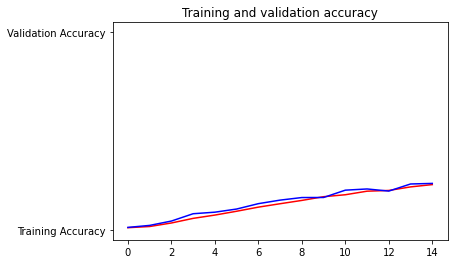

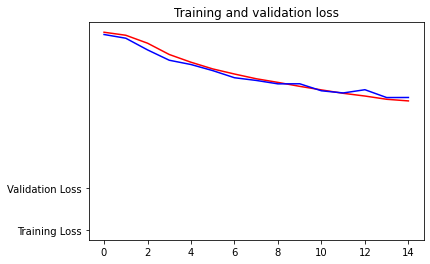

In [20]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

## Evaluating accuracy

In [21]:
STEP_SIZE_TEST = validation_set.samples // batch_size
loss, acc = model.evaluate_generator(generator=validation_set, steps=STEP_SIZE_TEST)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [22]:
print('The model has accuracy of: {:.4} %'.format(acc*100))

The model has accuracy of: 22.69 %
